Reload the notebook tab once and run again

In [1]:
import numpy as np
import pickle
import cv2
import os
from os import listdir
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
datasetDirectory = './plantvillage_dataset/segmented/'
width = 256
height = 256
depth = 3
BATCH_SIZE = 32
IMG_SIZE = (255, 255)

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, IMG_SIZE)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
for directory in listdir(datasetDirectory):
    if not 'Corn' in directory:
        continue
    print(f"Processing {directory} ...")
    plantDiseaseImageList = listdir(f"{datasetDirectory}/{directory}/")
    for plantImage in plantDiseaseImageList[:500]:
        if plantImage == ".DS_Store":
            continue
        imagePath = f"{datasetDirectory}/{directory}/{plantImage}"
        if imagePath.endswith(".jpg") == True or imagePath.endswith(
                ".JPG") == True:
            img = cv2.imread(imagePath, 0)
            img = cv2.resize(img, IMG_SIZE)
            image_list.append(np.asarray(img))
            label_list.append(directory)

Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
Processing Corn_(maize)___Common_rust_ ...
Processing Corn_(maize)___healthy ...
Processing Corn_(maize)___Northern_Leaf_Blight ...


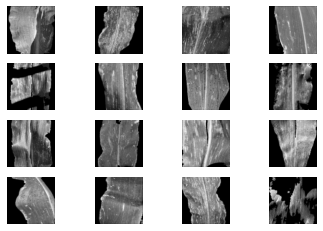

In [5]:
for i, img in enumerate(image_list):
    if i == 16:
        break
    plt.subplot(4,4,i + 1)
    plt.imshow(img.astype('float32'), cmap='gray')
    plt.axis('off')
plt.show()

In [6]:
from PIL import Image, ImageEnhance

new = Image.new("RGBA", (2000,1000))

img = Image.open("./plantvillage_dataset/segmented/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335_final_masked.jpg")
img = img.resize((500,500))
new.paste(img, (0,0))

img = Image.open("./plantvillage_dataset/segmented/Apple___Black_rot/0090d05d-d797-4c99-abd4-3b9cb323a5fd___JR_FrgE.S 8727_final_masked.jpg")
img = img.resize((500,500))
new.paste(img, (1000,0))

img = Image.open("./plantvillage_dataset/segmented/Apple___Cedar_apple_rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655_final_masked.jpg")
img = img.resize((500,500))
new.paste(img, (500,500))

img = Image.open("./plantvillage_dataset/segmented/Apple___healthy/00907d8b-6ae6-4306-bfd7-d54471981a86___RS_HL 5709_final_masked.jpg")
img = img.resize((500,500))
new.paste(img, (1500,500))

new.show()

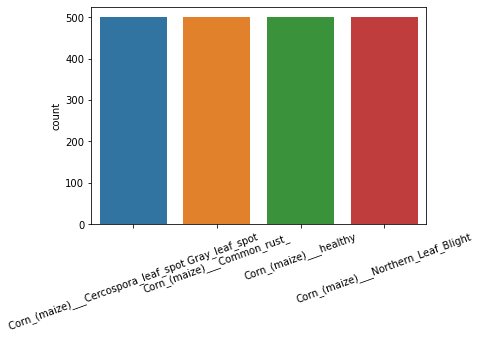

In [7]:
sns.countplot(x=label_list)
plt.xticks(rotation=20)
plt.show()

In [8]:
print(("Total number of images processing :", len(image_list)))

('Total number of images processing :', 2000)


In [9]:
# normalising images
image_list = np.array(image_list, dtype=np.float16) / 225.0

In [10]:
# encoding labels
encoder = LabelEncoder()
image_labels = encoder.fit_transform(label_list)
pickle.dump(encoder, open('label_transform.pkl', 'wb'))
n_classes = len(encoder.classes_)

In [11]:
# segregating images and labels into train and test
x_train, x_test, y_train, y_test = train_test_split(image_list,
                                                    image_labels,
                                                    test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=1)

In [12]:
x_train = x_train.reshape(1280, 65025)
x_test = x_test.reshape(400, 65025)


In [13]:
print(x_test.shape)

(400, 65025)


### Fuzzy KNN

In [14]:
def euclediandistance(data1, data2, length):
    distance=0
    for x in range(length):
        distance += np.square(data1[x]-data2[x])
    return np.sqrt(distance)

In [15]:
import scipy.spatial
from collections import Counter
from operator import itemgetter


class FKNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def getDistance(self, X1, X2):
        return scipy.spatial.distance.euclidean(X1, X2)

    def fuzzy(self, d, m):
        closestPoint = [d[k][1] for k in range(len(d))]
        classes = np.unique(self.y_train[closestPoint])
        arrMembership = []
        for cls in classes:
            atas = 0
            bawah = 0
            for close in d:
                if (close[0] != 0):
                    if (cls == self.y_train[close[1]]):
                        atas += np.power((1 / close[0]), (2 / (m - 1)))
                    else:
                        atas += np.power((0 / close[0]), (2 / (m - 1)))
                    bawah += np.power((1 / close[0]), (2 / (m - 1)))
                else:
                    atas += 0
                    bawah += 1
            arrMembership.append([atas / bawah, cls])
        return arrMembership

    def predict(self, X_test):
        final_output = []
        for i in range(len(X_test)):
            d = []
            votes = []
            for j in range(len(self.X_train)):
                dist = self.getDistance(self.X_train[j], X_test[i])
                d.append([dist, j])
            d.sort()
            d = d[0:self.k]
            membership = self.fuzzy(d, 2)
            predicted_class = sorted(membership,
                                     key=itemgetter(0),
                                     reverse=True)
            final_output.append(predicted_class[0][1])
        return final_output

    def score(self, X_test, y_test):
        predictions = self.predict(X_test)
        value = 0
        for i in range(len(y_test)):
            if (predictions[i] == y_test[i]):
                value += 1
        return value / len(y_test)

In [16]:
fknn = FKNN(9)

In [17]:
fknn.fit(x_train, y_train)

In [18]:
prediction = fknn.score(x_test, y_test)

In [19]:
print("Accuracy score: ", prediction)

Accuracy score:  0.7225


In [20]:
print((classification_report(fknn.predict(x_test), y_test)))

              precision    recall  f1-score   support

           0       0.63      0.65      0.64       105
           1       0.63      0.91      0.75        65
           2       0.64      0.60      0.62       108
           3       1.00      0.80      0.89       122

    accuracy                           0.72       400
   macro avg       0.73      0.74      0.72       400
weighted avg       0.75      0.72      0.73       400



### Bayesian SVM

In [21]:
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize
import cv2    
from sklearn.svm import SVC

from numpy import mean
from pandas import read_csv
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

In [22]:
search_space = list()
search_space.append(Real(1e-2, 10.0, 'log-uniform', name='C'))
search_space.append(Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='kernel'))
search_space.append(Integer(1, 5, name='degree'))
search_space.append(Real(1e-2, 10.0, 'log-uniform', name='gamma'))
 

In [23]:
@use_named_args(search_space)
def evaluate_model(**params):
    model = SVC()
    model.set_params(**params)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    result = cross_val_score(model, X, y, cv=cv, n_jobs=-1, scoring='accuracy')
    estimate = mean(result)
    return 1.0 - estimate

In [24]:
X = x_train[:100]
y = y_train[:100]

In [25]:
result = gp_minimize(evaluate_model, search_space)

C:\Users\nshra\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [26]:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: %s' % (result.x))

Best Accuracy: 0.690
Best Parameters: [0.06143570960042151, 'poly', 2, 0.2841512204676058]


In [27]:
model = SVC(gamma=0.018676379018010895, C=0.23911397476654192, kernel='linear', degree=1, probability=True)

In [28]:
model.fit(x_train, y_train)

SVC(C=0.23911397476654192, degree=1, gamma=0.018676379018010895,
    kernel='linear', probability=True)

In [29]:
prediction = model.score(x_test, y_test)

In [30]:
print("Accuracy score: ", prediction)

Accuracy score:  0.7325


In [31]:
print((classification_report(model.predict(x_test), y_test)))

              precision    recall  f1-score   support

           0       0.48      0.62      0.54        84
           1       0.86      0.91      0.88        88
           2       0.65      0.53      0.58       125
           3       0.98      0.92      0.95       103

    accuracy                           0.73       400
   macro avg       0.74      0.74      0.74       400
weighted avg       0.74      0.73      0.73       400



### KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
model = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
)

In [34]:
model.fit(x_train, y_train)

KNeighborsClassifier()

In [35]:
prediction = model.score(x_test, y_test)

In [36]:
print("Accuracy score: ", prediction)

Accuracy score:  0.73


In [37]:
print((classification_report(model.predict(x_test), y_test)))

              precision    recall  f1-score   support

           0       0.66      0.61      0.63       117
           1       0.67      0.90      0.77        69
           2       0.61      0.65      0.63        95
           3       1.00      0.82      0.90       119

    accuracy                           0.73       400
   macro avg       0.73      0.74      0.73       400
weighted avg       0.75      0.73      0.73       400



In [38]:
#DECISION TREE
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from collections import Counter
from sklearn.metrics import confusion_matrix


In [39]:
#print(x_train)

In [40]:
class ML:
    def __init__(self,x_train, x_test, y_train, y_test):
        self.x_train=x_train
        self.x_test=x_test
        self.y_train=y_train
        self.y_test=y_test
        self.models()
        
    def models(self):
        self.decisionTree = DecisionTreeClassifier()
        self.bayes= GaussianNB()
        self.svm= SVC(probability=True)

    def train(self, model):
        self.model = model
        print("Training data for {}".format(model))
        self.model.fit(self.x_train, self.y_train)
        print("Training completed")
        self.predicts()   
        
    def predicts(self):
        ypred = self.model.predict(self.x_test)
        print("Prediction is done")
        print("Accuracy Score : {}".format(accuracy_score(self.y_test, ypred)))
        print("Classification Report")
        print(classification_report(self.y_test, ypred))
        print("Confusion Matrix")
        df_cm = confusion_matrix(self.y_test, ypred)
        sns.set(font_scale=1.4) 
        sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
        plt.show()

In [41]:
algorithms=ML(x_train, x_test, y_train, y_test)

Training data for DecisionTreeClassifier()
Training completed
Prediction is done
Accuracy Score : 0.7425
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       108
           1       0.86      0.89      0.87        93
           2       0.57      0.56      0.56       102
           3       0.92      0.97      0.94        97

    accuracy                           0.74       400
   macro avg       0.74      0.75      0.75       400
weighted avg       0.74      0.74      0.74       400

Confusion Matrix


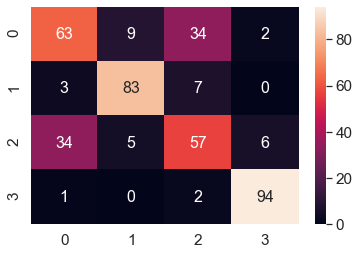

In [42]:
algorithms.train(algorithms.decisionTree)

Training data for GaussianNB()
Training completed
Prediction is done
Accuracy Score : 0.715
Classification Report
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       108
           1       0.75      0.84      0.79        93
           2       0.59      0.48      0.53       102
           3       0.90      0.95      0.92        97

    accuracy                           0.71       400
   macro avg       0.71      0.72      0.71       400
weighted avg       0.71      0.71      0.71       400

Confusion Matrix


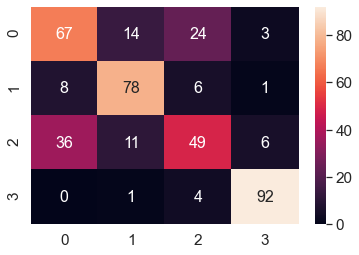

In [43]:
algorithms.train(algorithms.bayes)

Training data for SVC(probability=True)
Training completed
Prediction is done
Accuracy Score : 0.7875
Classification Report
              precision    recall  f1-score   support

           0       0.71      0.66      0.68       108
           1       0.86      0.89      0.87        93
           2       0.67      0.64      0.65       102
           3       0.91      0.99      0.95        97

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.78      0.79      0.78       400

Confusion Matrix


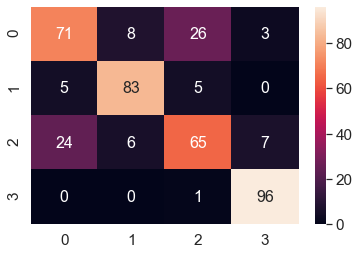

In [44]:
algorithms.train(algorithms.svm)

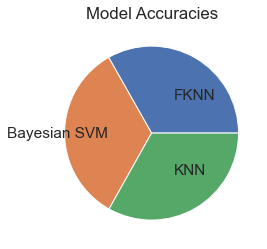

In [47]:
accuracies = [72.2, 73.2, 72]
models = ['FKNN', "Bayesian SVM", "KNN"]
plt.pie(accuracies, labels= models, labeldistance=0.5)
plt.title("Model Accuracies")
plt.show()